# scanflow example with a single app

# Setup

- Input: Application with the python files, data set and requirements.
- Output: Platform.

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:

from scanflow.setup import setup


app_dir = '/home/guess/Desktop/scanflow/examples/keras_sklearn'
workflow = {'gathering': 'gathering.py',
            'preprocessing': 'preprocessing.py',
            'modeling': 'modeling.py',
            'tuning': None,
            'main': 'main.py'}

platform = setup.Setup(app_dir, workflow)
platform

In [9]:
platform.pipeline()
platform

01-Oct-19 09:15:52 - Pipeline: build() and run() are running.
01-Oct-19 09:15:52 - Dockerfile was found.
01-Oct-19 09:15:52 - Image app_single was built successfully.
01-Oct-19 09:15:52 - MLproject was found.
01-Oct-19 09:15:53 - Image app_single is running as app_single container.
01-Oct-19 09:15:53 - MLflow server is running at 0.0.0.0:8001


In [7]:
# platform.stop()

01-Oct-19 09:15:15 - Container app_single was stopped.
01-Oct-19 09:15:15 - Stopped containers were deleted.


# Deploy

- Input: Platform object.
- Output: Workflow shown at Mlflow webserver http://localhost:8001/#/. API model at http://localhost:5001/#/

In [10]:
from scanflow import deploy

deployer = deploy.Deploy(platform)

deployer.pipeline()

01-Oct-19 09:15:58 - Pipeline: run_workflow() and deploy() are running.
01-Oct-19 09:15:58 - Running workflow: type=single .
01-Oct-19 09:16:03 -  Main file (main.py) output:  No matching run has been found.
2019/10/01 07:15:59 INFO mlflow.projects: === Created directory /tmp/tmpen4w8g9t for downloading remote URIs passed to arguments of type 'path' ===
2019/10/01 07:15:59 INFO mlflow.projects: === Running command 'python gathering.py' in run with ID 'e7229730bdea4bf88266288ab566f6fb' === 
1.2.0
        x_1       x_2       x_3       x_4  y
0 -1.887365 -1.145569  0.839676 -2.008856  0
1 -0.182668 -0.122267  0.082513 -0.205466  0
2 -0.731595  0.655904  0.205311  0.287141  0
3 -0.774965  0.744027  0.212103  0.351875  0
4 -1.339423 -1.042463  0.620971 -1.647999  0
2019/10/01 07:15:59 INFO mlflow.projects: === Run (ID 'e7229730bdea4bf88266288ab566f6fb') succeeded ===
No matching run has been found.
2019/10/01 07:15:59 INFO mlflow.projects: === Created directory /tmp/tmpgwemvohv for download

## Track


- Input: Values to predict.
- Output: Predictions and analysis.

In [6]:
from scanflow.deploy import deploy

deployer = deploy.Deploy(api_image_name='app_single_api')
deployer.run_api()


23-Oct-19 10:46:18 -  INFO - Creating container: app_single_api. 
23-Oct-19 10:46:18 -  INFO - API model is running as app_single_api container.
23-Oct-19 10:46:18 -  INFO - Container: app_single_api was created successfully. 
23-Oct-19 10:46:19 -  INFO - API at: htpp://localhost:5001. 


In [8]:
from sklearn.datasets import make_classification
from scanflow.track import track

tracker = track.Track(port=5001)

X2, y2 = make_classification(n_samples=100,n_features=4,
                            class_sep=1.1, n_informative=2,
                            n_redundant=1, random_state=42)
sample_input = { 
        "columns": [ 
            "x_1", 
            "x_2", 
            "x_3", 
            "x_4", 
        ], 
        "data": X2.tolist()
        # "data": [ 
        #     [-1.8873649,-1.1455,0.83967,-2.008855],
        #     [-0.989919,  0.987401, 0.266892,  0.485329]  
        # ] 
}   

path = '/home/guess/Desktop/scanflow/examples/keras_sklearn'
predictions = tracker.predict(sample_input, to_save=True, path_pred=path)
# tracker.save_prediction(path)

predictions.head()
# print(f'Predictions: \n {predictions}')

23-Oct-19 10:59:12 -  INFO - Predicting from port: 5001
23-Oct-19 10:59:12 -  INFO - Time elapsed: 0.03157949447631836
23-Oct-19 10:59:12 -  INFO - Input and predictions were saved at: /home/guess/Desktop/scanflow/examples/keras_sklearn/predictions.csv


,x_1,x_2,x_3,x_4,pred
0,-0.589365,0.279897,1.033440,0.788119,0.056820
1,-0.600217,1.618641,0.055132,2.098053,0.751936
2,0.443819,-1.286665,1.122556,-1.183247,0.480628
3,-1.430141,1.096537,-1.385680,0.830198,0.611223
4,1.032465,-0.759101,2.691239,0.144724,0.134751


In [17]:
# %store predictions

### Gather a sample from the training data and new distribution


It aims at checking the sanity of new data; basically, test integrity (same numbers of features, class labels, types, etc.) and draft distributions (tests, e.g. Kolmogorov.).

########## Comparing two numerical dataframes ##########

######## Kolmogorov-Smirnov test ########
                        x_1         x_2          x_3         x_4
p_value             0.21117    0.469506  3.75191e-06    0.469506
explain  Slightly different  Comparable    Different  Comparable


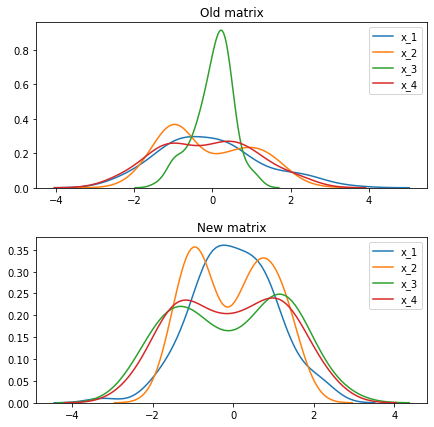

In [10]:
import pandas as pd
from scanflow.track import tools

old_data_path = '/home/guess/Desktop/scanflow/examples/keras_sklearn/workflow/raw_data.csv'
X_old = pd.read_csv(old_data_path)
X_old = X_old.loc[:, X_old.columns != 'y']
X_new = predictions.loc[:, predictions.columns != 'pred']

tools.overall_test(X_old.sample(len(X_new)), X_new, verbose=True)


# X_old.head()
# assert integrity_checker(X_old) == integrity_checker(X_new)
# tracker.overall_test(X_old, X_new)

# Comparison

# Mlflow vs scanflow
| Features             | MLflow                                                 | scanflow                                                               |
|----------------------|--------------------------------------------------------|--------------------------------------------------------------------------|
| Track of experiments | Any stage in the ML workflow with logs and artifacts. | Based on MLflow but with some built-in  functions to standard workflows (single, cluster). |
| Reproduce code       | Conda environment and Dockerfile  manually filled.     | User provides basic config (requirements) and the environment is created automatically |
| Deploy models        | Built-in functions, no tracking.                                | Based on MLflow with add-ons tools  to track the deployed models.        |
| Replication          | It is handled by hand.                       | Specify the number of replicas in the  deployment stage.                 |
| Learning curve       | Medium, Python and  command line scripts.              | Easy, everything is written in Python.                                   |

Similar to the relationship between Tensorflow and Keras

## Why is it useful?

- One of the hardest part of ML productionalizing lays on making the model easy to track, easy to deploy and easy to maintain. That's why having tools that lead to rapid prototyping and easy interpretation is crucial.

- Due to all the output work is based on Docker, it will be easily deploy in any environment, whether on-premise or cloud.

- **The main goal is to automate the model's life after modeling. It means, automate the post-modeling stage.**


## Unique features for docker container that contains ML models.

# Plugins

## Test data augmentation: generate new feedbacks

In [ ]:

new_feedbacks = tracker.generate_feedbacks(feedbacks)

augmented_data = X_old+new_feedbacks
model.train(augmented_data)

new_predictions = model.predict(X_hidden)
print(model.evaluate(new_predictions , y_hidden))


### If the new model is better then the data augmentation has worked succesfully.

Old score = 0.81

New score = 0.83

### TODO


- Show predictions in a better way.
- Comparison with mlflow.
- helping in a data analysis
- Replication when using several containers
- Change position of mlruns (artifacts)
- Change loginfo deploy (5001)